Comparing nemo 3.4 with and without key_ldfslp.

In [1]:
%matplotlib inline
from matplotlib import pylab
import matplotlib.pyplot as plt
import matplotlib as mpl
import netCDF4 as NC
import numpy as np
import scipy.interpolate as sp
import math

import datetime

from salishsea_tools import stormtools, nc_tools, viz_tools


In [2]:
#load up the bathymetry. 
grid = NC.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc','r')
bathy = grid.variables['Bathymetry'][:,:]
X = grid.variables['nav_lon'][:,:]
Y = grid.variables['nav_lat'][:,:]

In [3]:
#load in the datas. Trying something new with dict objects...

#first run (3.4)
r1 = 'initial';
runname1 = '/data/nsoontie/MEOPAR/SalishSea/results/merge-tests/merg2015/' + r1 
print runname1

#second run without key_ldfslp
r2 = 'no_ldfslp'
#runname2 = '/ocean/sallen/allen/research/MEOPAR/nemo-3.6-code/NEMOGCM/CONFIG/SalishSea/EXP00/'
runname2= '/data/nsoontie/MEOPAR/SalishSea/results/merge-tests/merg2015/' + r2
print runname2

runs = {r1: runname1, r2: runname2}


/data/nsoontie/MEOPAR/SalishSea/results/merge-tests/merg2015/initial
/data/nsoontie/MEOPAR/SalishSea/results/merge-tests/merg2015/no_ldfslp


In [4]:
fUs={}; fVs={}; fTs={}
for key, path in runs.iteritems():
    if key == r1:
        fUs[key] = NC.Dataset(path +'/SalishSea_1h_20121214_20121215_grid_U.nc','r');
        fVs[key] = NC.Dataset(path +'/SalishSea_1h_20121214_20121215_grid_V.nc','r');
        fTs[key] = NC.Dataset(path +'/SalishSea_1h_20121214_20121215_grid_T.nc','r');
    else:
        fUs[key] = NC.Dataset(path +'/SalishSea_1h_20121214_20121214_grid_U.nc','r');
        fVs[key] = NC.Dataset(path +'/SalishSea_1h_20121214_20121214_grid_V.nc','r');
        fTs[key] = NC.Dataset(path +'/SalishSea_1h_20121214_20121214_grid_T.nc','r');

Show info about the files

In [5]:
for key in runs:
    print key
    nc_tools.show_dataset_attrs(fUs[key])

initial
file format: NETCDF4
Conventions: CF-1.1
production: An IPSL model
TimeStamp: 28/05/2015 14:51:46 -0700
file_name: SalishSea_1h_20121214_20121215_grid_U.nc
history: Thu May 28 14:54:57 2015: ncks -4 -L4 -O SalishSea_1h_20121214_20121215_grid_U.nc SalishSea_1h_20121214_20121215_grid_U.nc
NCO: 4.4.2
no_ldfslp
file format: NETCDF4
Conventions: CF-1.1
production: An IPSL model
TimeStamp: 05/07/2015 10:23:27 -0700
file_name: SalishSea_1h_20121214_20121214_grid_U.nc
history: Sun Jul  5 10:24:25 2015: ncks -4 -L4 -O SalishSea_1h_20121214_20121214_grid_U.nc SalishSea_1h_20121214_20121214_grid_U.nc
NCO: 4.4.2


In [6]:
for key in runs:
    print key
    nc_tools.show_variable_attrs(fUs[key])

initial
<type 'netCDF4.Variable'>
float32 depthu(depthu)
    axis: Z
    standard_name: model_level_number
    units: m
    positive: down
    valid_min: 0.5
    valid_max: 441.466
    title: depthu
    long_name: Vertical U levels
unlimited dimensions: 
current shape = (40,)
filling on, default _FillValue of 9.96920996839e+36 used

<type 'netCDF4.Variable'>
float32 nav_lat(y, x)
    standard_name: latitude
    units: degrees_north
    valid_min: 46.8606
    valid_max: 51.1056
    long_name: Latitude
    nav_model: Default grid
unlimited dimensions: 
current shape = (898, 398)
filling on, default _FillValue of 9.96920996839e+36 used

<type 'netCDF4.Variable'>
float32 nav_lon(y, x)
    standard_name: longitude
    units: degrees_east
    valid_min: -126.397
    valid_max: -121.316
    long_name: Longitude
    nav_model: Default grid
unlimited dimensions: 
current shape = (898, 398)
filling on, default _FillValue of 9.96920996839e+36 used

<type 'netCDF4.Variable'>
float64 time_counter(t

Different sizes because initial is 48 hours. 

In [7]:

#U,V,SSH,Salinity,Temperature
Us={}; Vs={}; Es={}; Ss={}; Ts={}; Ds={}
t_orig = {}
tim_count={}

for key in runs:
    Us[key] = fUs[key].variables['vozocrtx']
    Vs[key] = fVs[key].variables['vomecrty']
    Es[key] = fTs[key].variables['sossheig']
    Ss[key] = fTs[key].variables['vosaline']
    Ts[key] = fTs[key].variables['votemper']
    Ds[key] = fTs[key].variables['deptht']
    tim_count[key] = fUs[key].variables['time_counter']
    t_orig[key] = datetime.datetime.strptime(
                    tim_count[key].time_origin.title(), ' %Y-%b-%d %H:%M:%S')


#Comparison plots

Quick look at surface fields near the start and end of first day

In [8]:
def plot_variable(t,depthlevel,var, var_name,vmin=-3,vmax=3,diffmin=-0.1, diffmax=0.1,figsize=(15,5),ssh_flag=False, 
                  limits=[0,398,0,898]):
    """Compare a variable by plotting at time t and depth level, and their difference. 
    Colorbar limits set by vmin,vmax and diffmin, diffmax for the difference plot. 
    Use ssh_flag=True of plotting sea surface height
    Axis limits set by limits: [xmin,xmax,ymin,ymax]"""
    
    #plot
    fig, axs=plt.subplots(1,3,figsize=figsize)
    for key,ax in zip(runs,axs[0:2]):
        tims = tim_count[key][t]
        out= t_orig[key] + datetime.timedelta(seconds=tims)
        if ssh_flag:
            mesh=ax.pcolormesh(var[key][t,:,:],vmin=vmin,vmax=vmax)
        else:
            mesh=ax.pcolormesh(var[key][t,depthlevel,:,:],vmin=vmin,vmax=vmax)
        ax.set_title('{} at {}'.format(key,out.strftime('%d-%b-%Y %H:%M:%S')))
        cbar = plt.colorbar(mesh,ax=ax)
        cbar.set_label(var_name)
        viz_tools.plot_land_mask(ax,grid,isobath=depthlevel)
        ax.set_xlim([limits[0],limits[1]])
        ax.set_ylim([limits[2],limits[3]])
    ax=axs[2]
    if ssh_flag:
        diff = var[r1][t,:,:]-var[r2][t,:,:]
    else:
        diff = var[r1][t,depthlevel,:,:]-var[r2][t,depthlevel,:,:]
    mesh = ax.pcolormesh(diff, vmin=diffmin, vmax=diffmax, cmap = 'bwr')
    ax.set_title(r1+' - ' +r2)
    cbar = plt.colorbar(mesh,ax=ax)
    cbar.set_label('difference in ' +var_name)
    viz_tools.plot_land_mask(ax,grid,isobath=depthlevel)
    ax.set_xlim([limits[0],limits[1]])
    ax.set_ylim([limits[2],limits[3]])

Initial time, surface

Time = 0, depth level = 0


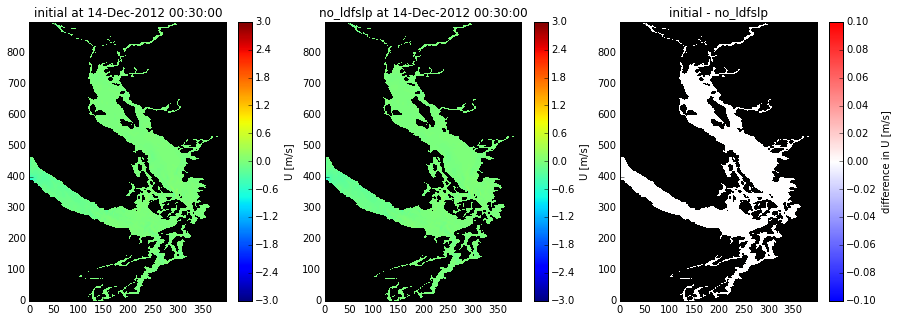

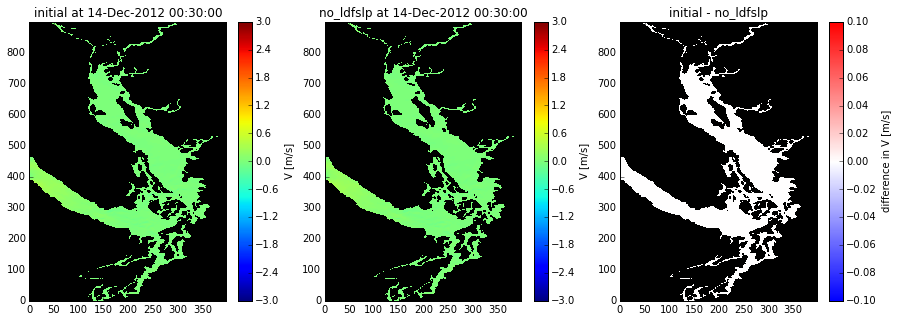

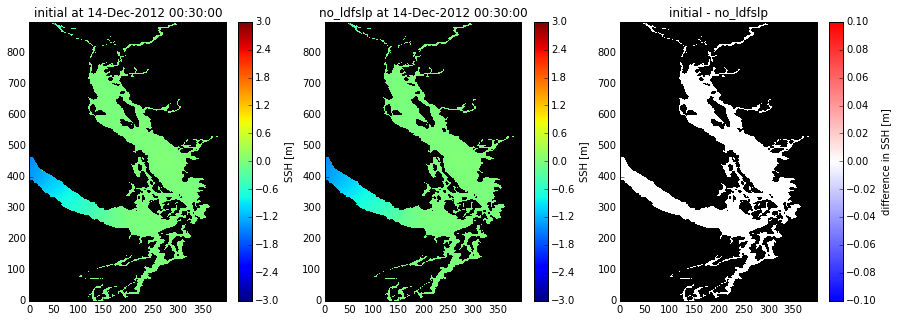

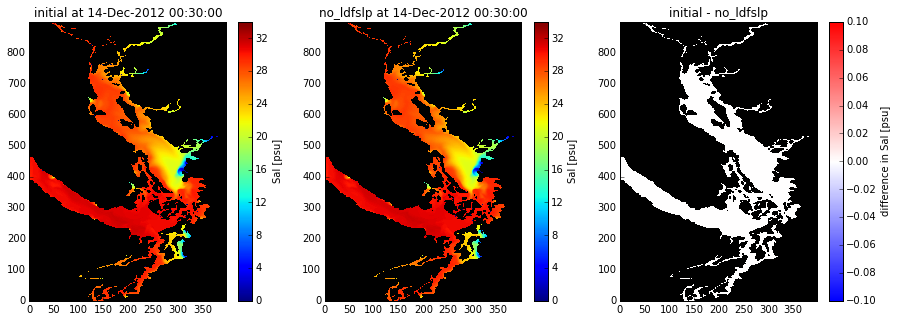

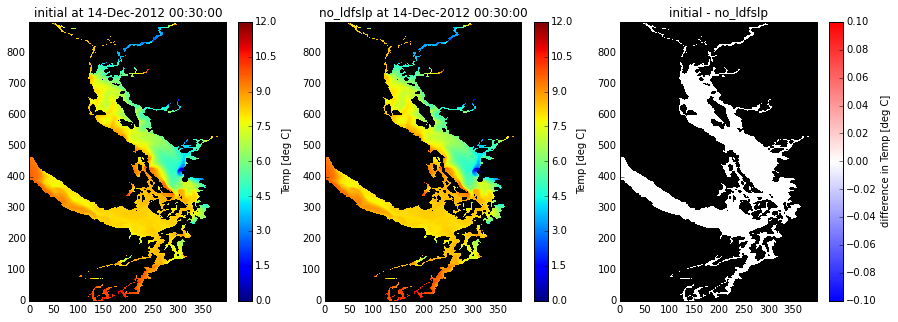

In [9]:
t=0
depthlevel=0

print 'Time = {}, depth level = {}'.format(t,depthlevel)
plot_variable(t,depthlevel,Us,'U [m/s]')
plot_variable(t,depthlevel,Vs,'V [m/s]')
plot_variable(t,depthlevel,Es,'SSH [m]', ssh_flag=True)
plot_variable(t,depthlevel,Ss,'Sal [psu]', vmin=0,vmax=34)
plot_variable(t,depthlevel,Ts,'Temp [deg C]', vmin=0,vmax=12)

Initially, not much difference

Time = 23, depth level = 0


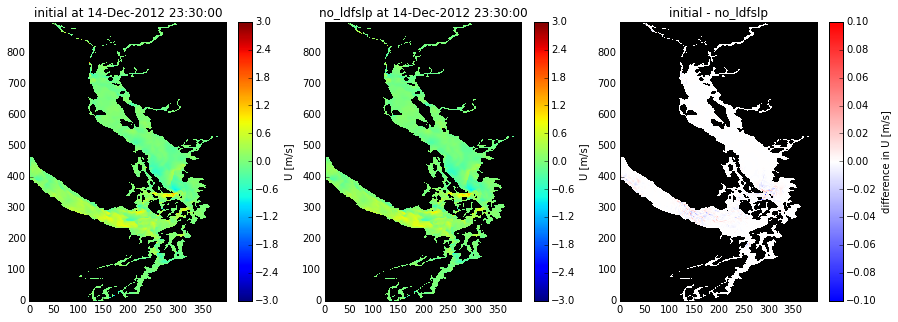

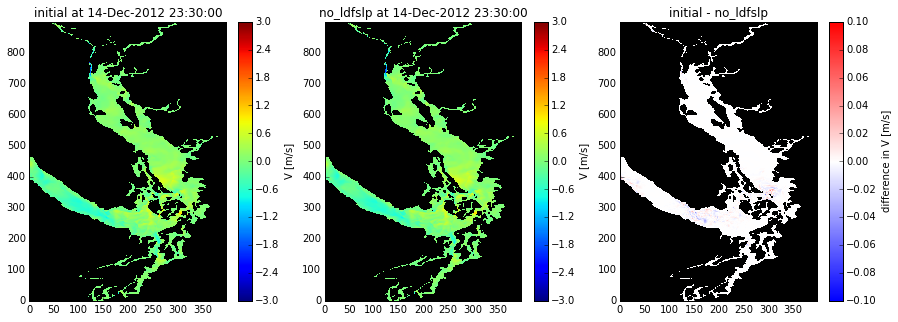

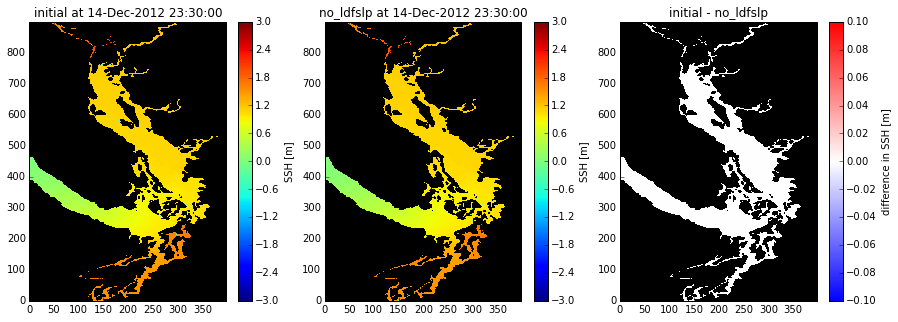

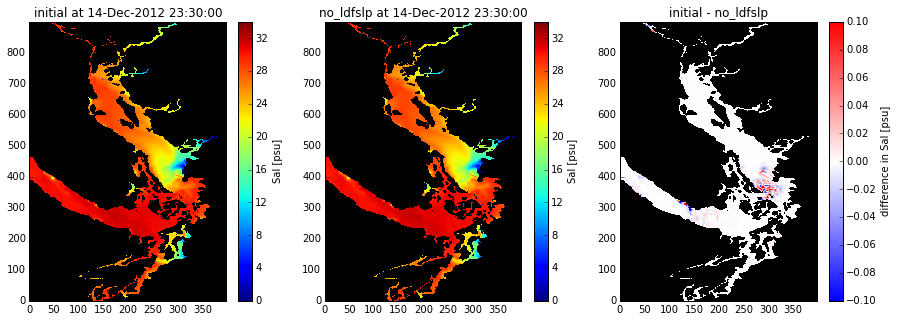

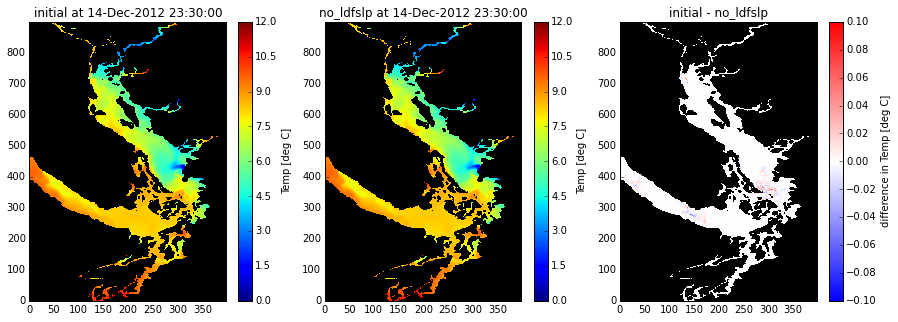

In [10]:
t=23
depthlevel=0

print 'Time = {}, depth level = {}'.format(t,depthlevel)
plot_variable(t,depthlevel,Us,'U [m/s]')
plot_variable(t,depthlevel,Vs,'V [m/s]')
plot_variable(t,depthlevel,Es,'SSH [m]', ssh_flag=True)
plot_variable(t,depthlevel,Ss,'Sal [psu]', vmin=0,vmax=34)
plot_variable(t,depthlevel,Ts,'Temp [deg C]', vmin=0,vmax=12)

* Localised differences in U/V and sal/temp
* The largest differences seem to be around mixing areas (plume, boundary pass)

## Zoom islands and north

Time = 23, depth level = 0


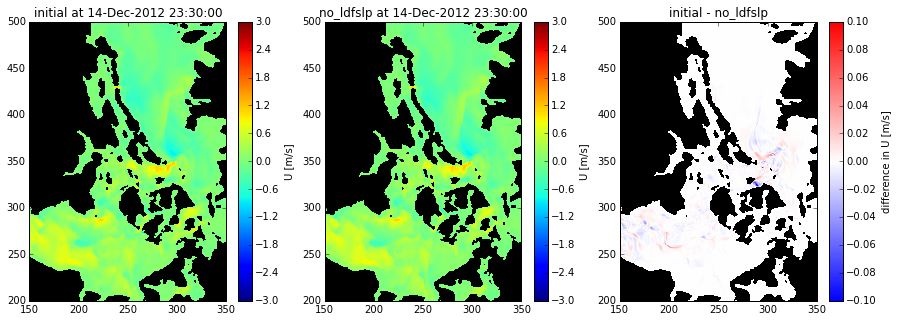

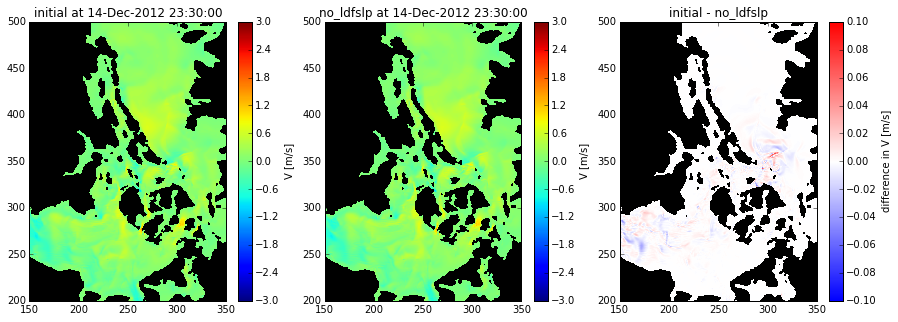

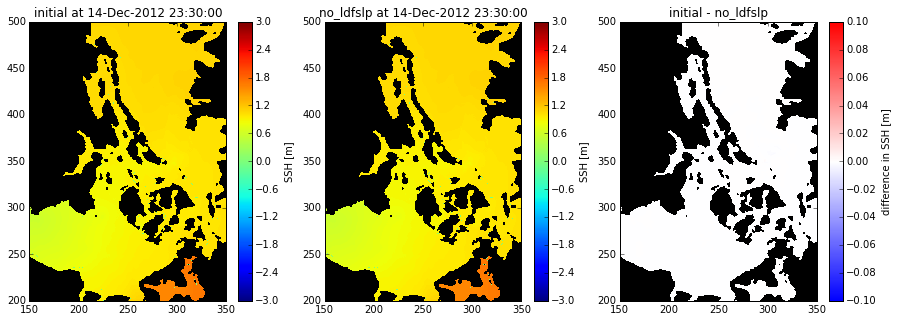

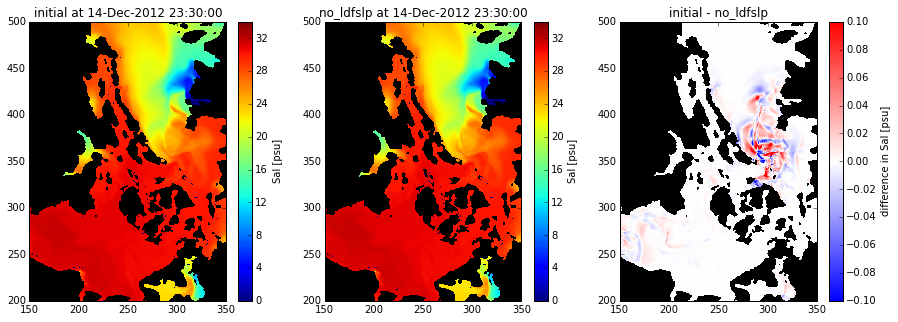

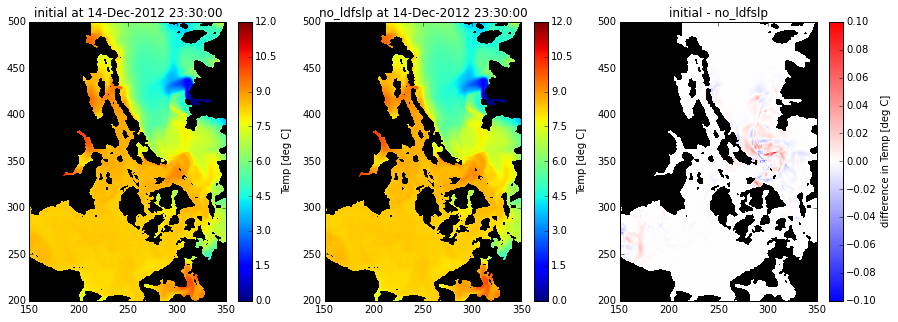

In [11]:
t=23
depthlevel=0
lims=[150,350,200,500]

print 'Time = {}, depth level = {}'.format(t,depthlevel)
plot_variable(t,depthlevel,Us,'U [m/s]',limits=lims)
plot_variable(t,depthlevel,Vs,'V [m/s]',limits=lims)
plot_variable(t,depthlevel,Es,'SSH [m]', ssh_flag=True,limits=lims)
plot_variable(t,depthlevel,Ss,'Sal [psu]', vmin=0,vmax=34,limits=lims)
plot_variable(t,depthlevel,Ts,'Temp [deg C]', vmin=0,vmax=12,limits=lims)

## Zoom North

Time = 23, depth level = 0


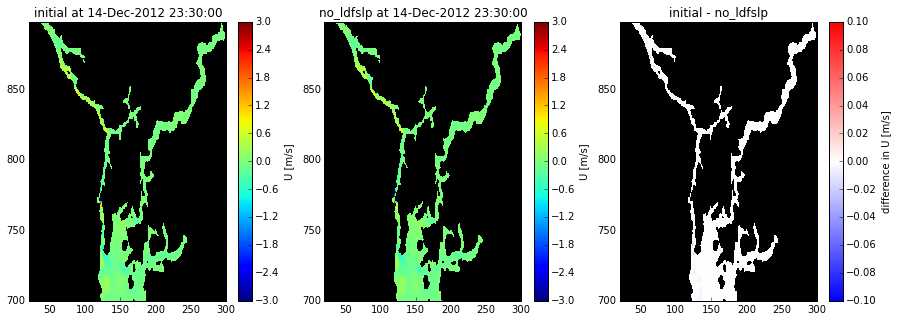

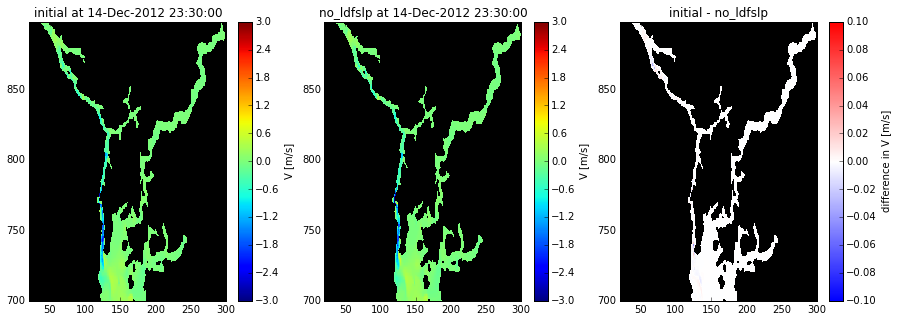

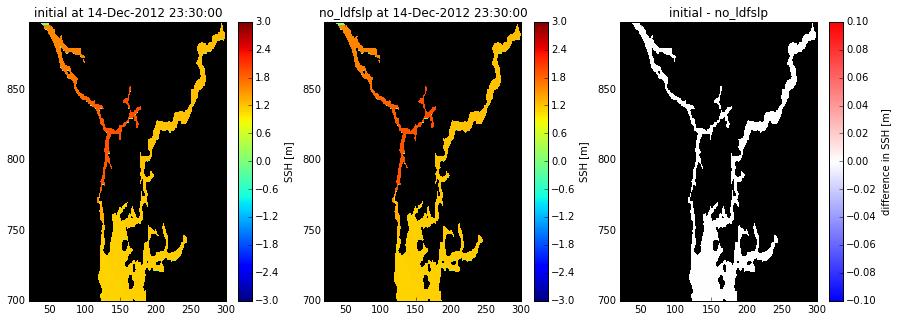

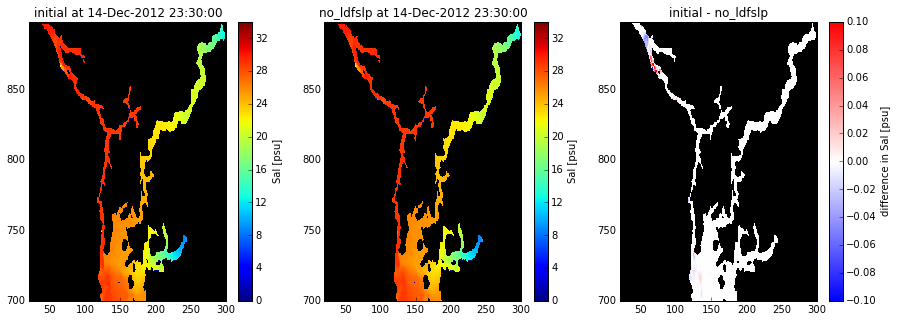

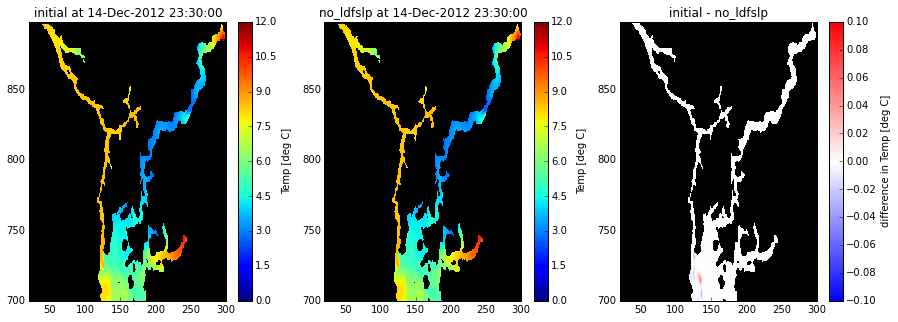

In [12]:
t=23
depthlevel=0
lims=[20,300,700,898]

print 'Time = {}, depth level = {}'.format(t,depthlevel)
plot_variable(t,depthlevel,Us,'U [m/s]',limits=lims)
plot_variable(t,depthlevel,Vs,'V [m/s]',limits=lims)
plot_variable(t,depthlevel,Es,'SSH [m]', ssh_flag=True,limits=lims)
plot_variable(t,depthlevel,Ss,'Sal [psu]', vmin=0,vmax=34,limits=lims)
plot_variable(t,depthlevel,Ts,'Temp [deg C]', vmin=0,vmax=12,limits=lims)

How big are the differences? The differences plots are saturated in Temp/Sal. But do the difference get much larger than +-0.1?

#Differences

Calculate simple staistics on the differences between fields. min/max/mean...

In [13]:
def summarize_differences(var,var_name,imin=0,imax=396,jmin=0,jmax=896):
    """print min,max, mean difference in a variable between simulations. Also prints indices of max/min.
    Statistics computed in region defined byt [imin,imax,jimn,jmax]"""
    
    diff = var[r1][0:24,...,jmin:jmax+1,imin:imax+1]-var[r2][...,jmin:jmax+1,imin:imax+1]
    inds_min = np.argmin(diff); inds_min=np.unravel_index(inds_min,diff.shape)
    inds_max = np.argmax(diff); inds_max=np.unravel_index(inds_max,diff.shape)
    print var_name
    print 'min diff: {0:.3}, index {1}'.format(diff.min(),inds_min)
    print 'max diff: {0:.3}, index {1}'.format(diff.max(),inds_max)
    print 'mean diff {0:.3}'.format(diff.mean())

In [14]:
variables = {'U [m/s]': Us,  'V [m/s]': Vs, 'SSH [m]': Es, 'Sal [psu]': Ss, 'Temp [deg C]': Ts}
for key in variables:
    summarize_differences(variables[key],key)

V [m/s]
min diff: -0.265, index (9, 24, 858, 83)
max diff: 0.258, index (14, 0, 329, 268)
mean diff -4.4e-07
Temp [deg C]
min diff: -0.468, index (10, 0, 357, 300)
max diff: 0.509, index (11, 0, 428, 244)
mean diff -1.48e-07
SSH [m]
min diff: -0.0303, index (9, 769, 121)
max diff: 0.0268, index (9, 771, 120)
mean diff -1.59e-05
U [m/s]
min diff: -0.4, index (13, 0, 329, 308)
max diff: 0.245, index (19, 0, 279, 141)
mean diff 2.67e-06
Sal [psu]
min diff: -1.38, index (12, 0, 866, 67)
max diff: 1.07, index (11, 0, 361, 301)
mean diff 3.89e-06


* Largest differences are mostly at the surface, about halfway through the day but at different times depending on the variable.
* Largest differences loook to be in the plume/boundary pass area or near the north.
* Velocity can have a pointwise difference up to 40cm/s, salinity up to ~1 psu

# Differences plot half day

Time = 12, depth level = 0


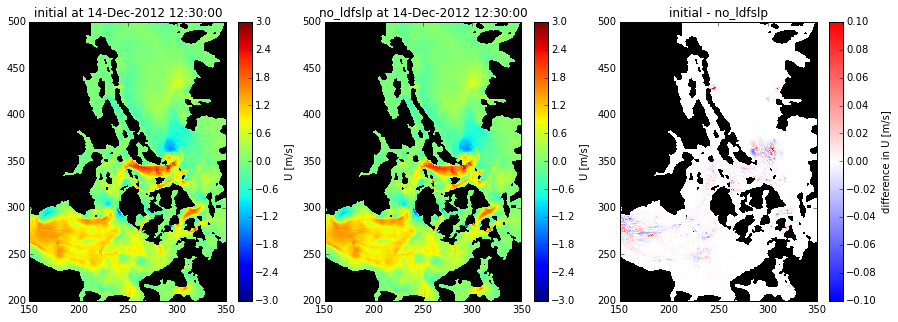

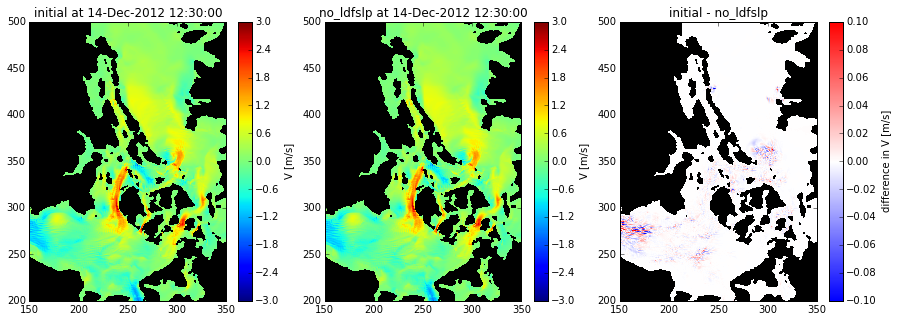

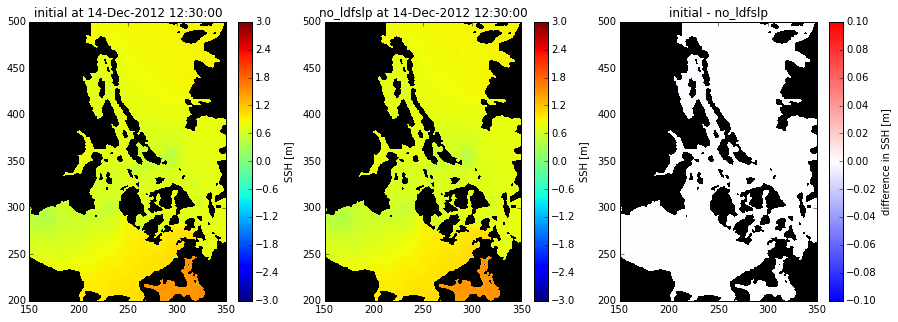

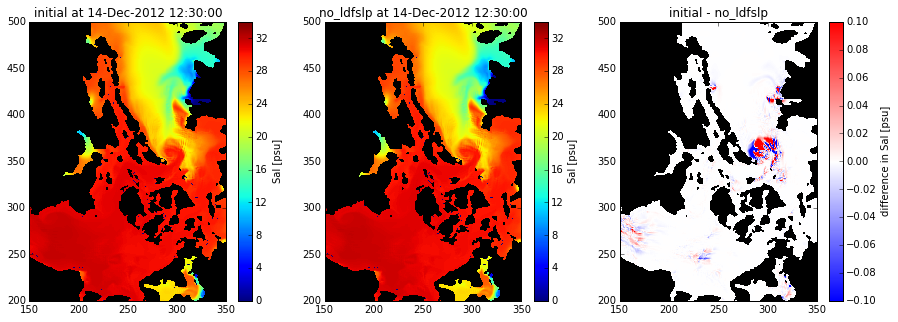

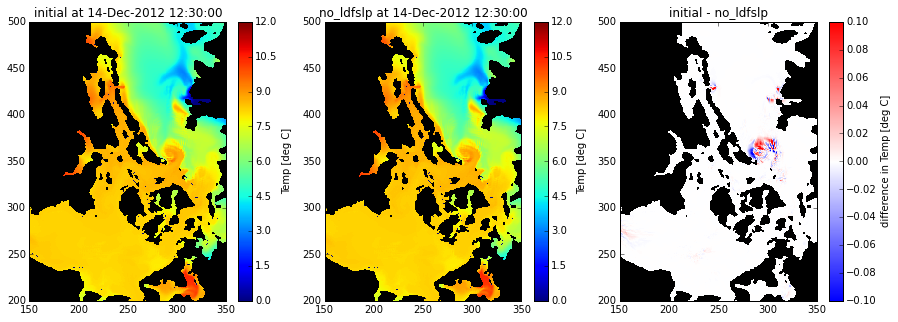

In [15]:
t=12
depthlevel=0
lims=[150,350,200,500]

print 'Time = {}, depth level = {}'.format(t,depthlevel)
plot_variable(t,depthlevel,Us,'U [m/s]',limits=lims)
plot_variable(t,depthlevel,Vs,'V [m/s]',limits=lims)
plot_variable(t,depthlevel,Es,'SSH [m]', ssh_flag=True,limits=lims)
plot_variable(t,depthlevel,Ss,'Sal [psu]', vmin=0,vmax=34,limits=lims)
plot_variable(t,depthlevel,Ts,'Temp [deg C]', vmin=0,vmax=12,limits=lims)

#Profiles

Laregest differences are in the surface layer. What do the depth profiles look like?

In [16]:
def compare_profile(var,var_name, i,j,t,zmin=0,zmax=400,vmin=0,vmax=34):
    """Function to compare a variable over depth at point i,j and time t.
    Plots each sim on the same axis and then their difference over depth"""

    fig,axs=plt.subplots(1,2,figsize=(10,5))
    ax=axs[0]
    for key in runs:
        tims = tim_count[key][t]
        out= t_orig[key] + datetime.timedelta(seconds=tims)
        ax.plot(var[key][t,:,j,i],Ds[key], '-o',label=key)
    ax.set_title(out.strftime('%d-%b-%Y %H:%M:%S'))
    ax.set_xlabel(var_name)
    ax.set_ylabel('Depth [m]')
    ax.set_ylim([zmax,zmin])
    ax.set_xlim([vmin,vmax])
    ax.legend(loc=0)
    ax=axs[1]
    #difference    
    diff = var[r1][t,:,j,i]-var[r2][t,:,j,i]
    ax.plot(diff,Ds[key], '-ro')
    ax.set_title('Difference: ' +r1+' - ' +r2)
    ax.set_xlabel('Difference in ' + var_name)
    ax.set_ylabel('Depth [m]')
    ax.set_ylim([zmax,zmin])
    

Near Fraser River Mouth, last time

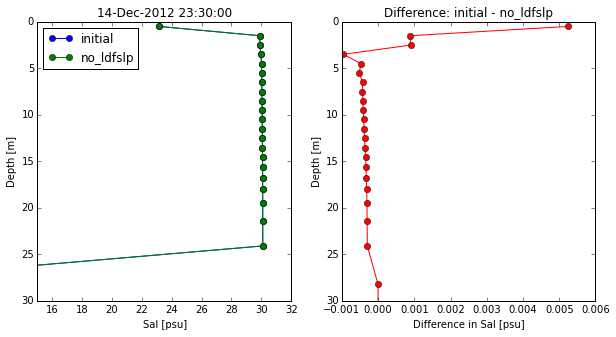

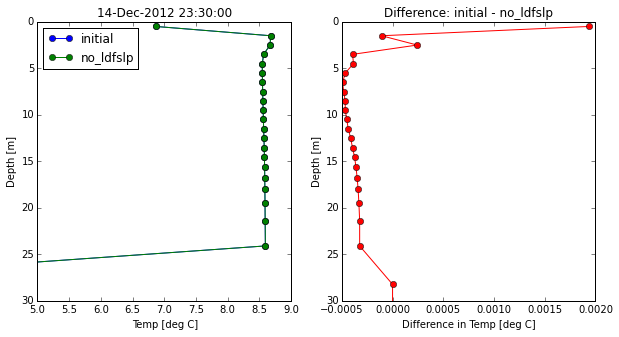

In [17]:
tp = 23
ip = 300
jp= 400
zmax=30
compare_profile(Ss,'Sal [psu]', ip,jp,tp,zmin=0,zmax=zmax,vmin=15,vmax=32)
compare_profile(Ts,'Temp [deg C]', ip,jp,tp,zmin=0,zmax=zmax,vmin=5,vmax=9)

Wow, huge jump in salinity over a grid cell (both profiles)

Max diff in salinity

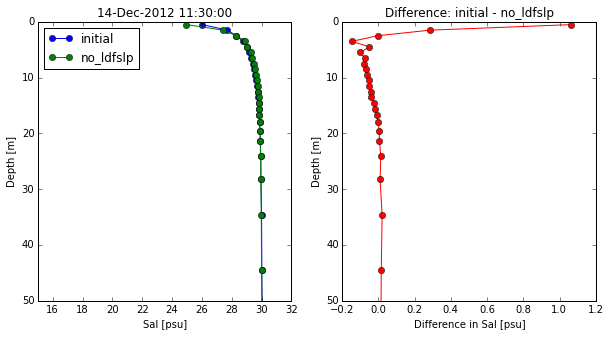

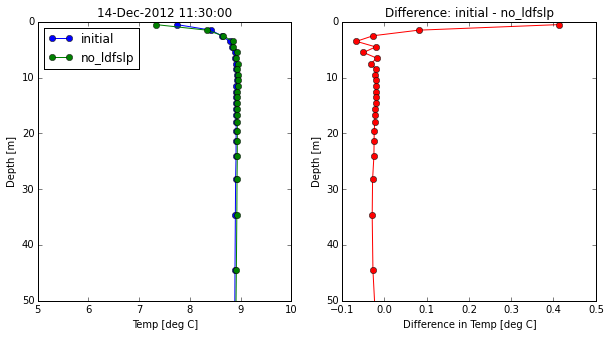

In [18]:
tp = 11
ip = 301
jp= 361
zmax=50
compare_profile(Ss,'Sal [psu]', ip,jp,tp,zmin=0,zmax=zmax,vmin=15,vmax=32)
compare_profile(Ts,'Temp [deg C]', ip,jp,tp,zmin=0,zmax=zmax,vmin=5,vmax=10)

* Differences in horizontal mixing, vertical mixing or both?

#Bounday conditions

How do the ssh/u/v near the boundaries compare?


Next to boundary

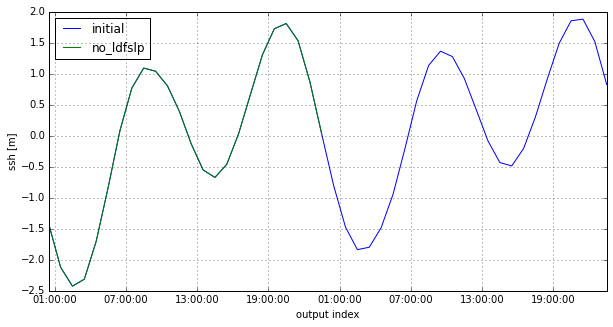

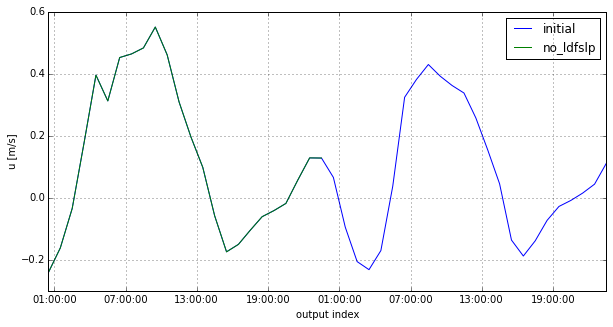

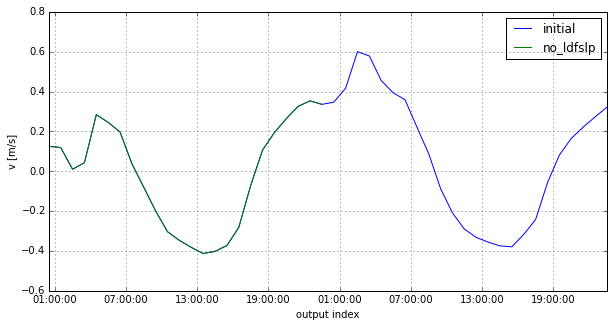

In [19]:
sshs={}
us={}
vs={}
i=2
j=450
dtimes={}

for key in runs:
    sshs[key] = fTs[key].variables['sossheig'][:,j,i]
    us[key] = fUs[key].variables['vozocrtx'][:,0,j,i]
    vs[key] = fVs[key].variables['vomecrty'][:,0,j,i]
    time_count = fTs[key].variables['time_counter'][:]
    dtimes[key]= [t_orig[key]+datetime.timedelta(seconds=t) for t in time_count]
    
fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],sshs[key],label=key)
ax.set_ylabel('ssh [m]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],us[key],label=key)
ax.set_ylabel('u [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],vs[key],label=key)
ax.set_ylabel('v [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

North

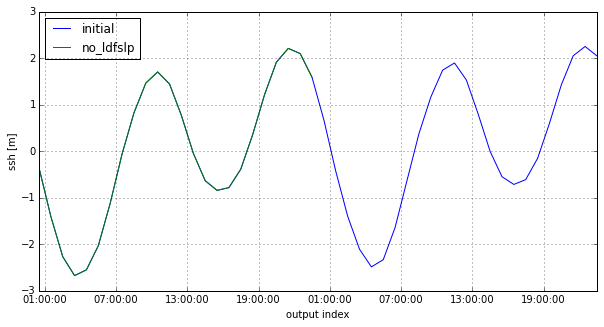

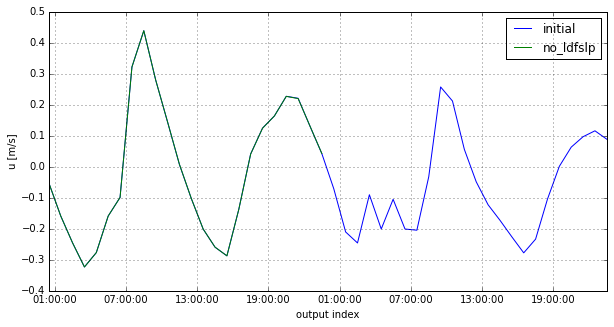

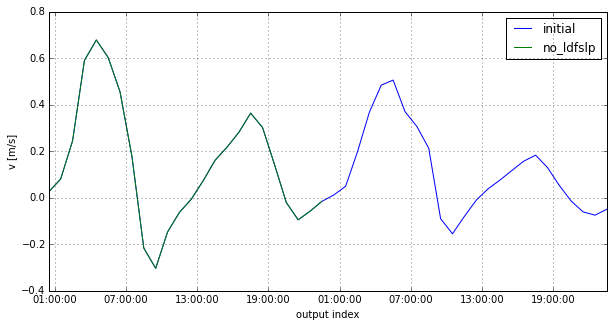

In [20]:
sshs={}
us={}
vs={}
i=50
j=894
dtimes={}

for key in runs:
    sshs[key] = fTs[key].variables['sossheig'][:,j,i]
    us[key] = fUs[key].variables['vozocrtx'][:,0,j,i]
    vs[key] = fVs[key].variables['vomecrty'][:,0,j,i]
    time_count = fTs[key].variables['time_counter'][:]
    dtimes[key]= [t_orig[key]+datetime.timedelta(seconds=t) for t in time_count]
    
fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],sshs[key],label=key)
ax.set_ylabel('ssh [m]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],us[key],label=key)
ax.set_ylabel('u [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],vs[key],label=key)
ax.set_ylabel('v [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

* U/V/SSH at boundaries at essentially identical. 
* ldfslp does not explain the difference at the boundaries

# Closer look at currents at SJdF boundary

Compare fields over depth and along the JdF boundary

In [21]:
def compare_slice(var, var_name, irange, jrange, t,vmin=-1,vmax=1,diffmin=-0.5,diffmax=0.5):
    """compare variables over depth along a slice defined by irange and jrange. 
    One of irange or jrange should be ar single value"""
    fig,axs=plt.subplots(1,3,figsize=(15,3))
    
    for ax, key in zip(axs[0:2],[r1,r2]):
        tims = tim_count[key][t]
        out= t_orig[key] + datetime.timedelta(seconds=tims)
        masked_var = np.ma.masked_values(var[key][t,:,jrange,irange],0)
        mesh=ax.pcolormesh(masked_var,vmin=vmin,vmax=vmax)
        ax.set_title('{} at {}'.format(key,out.strftime('%d-%b-%Y %H:%M:%S')))
        cbar = plt.colorbar(mesh,ax=ax)
        cbar.set_label(var_name)
        ax.invert_yaxis()

    ax=axs[2]
    diff = var[r1][t,:,jrange,irange]-var[r2][t,:,jrange,irange]
    diff=np.ma.masked_values(diff,0)
    mesh = ax.pcolormesh(diff,vmin=diffmin,vmax=diffmax)
    ax.set_title(r1+' - ' +r2)
    cbar = plt.colorbar(mesh,ax=ax)
    cbar.set_label('difference in ' +var_name)
    ax.invert_yaxis()

Early time

Mouth of JdF at t = 0


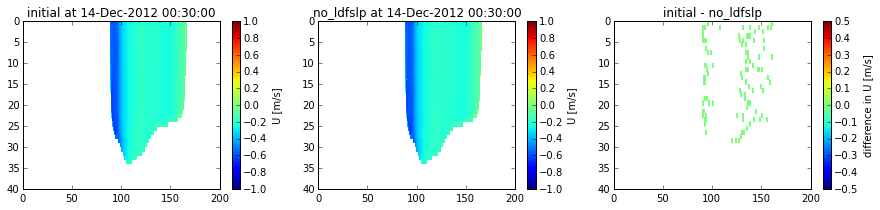

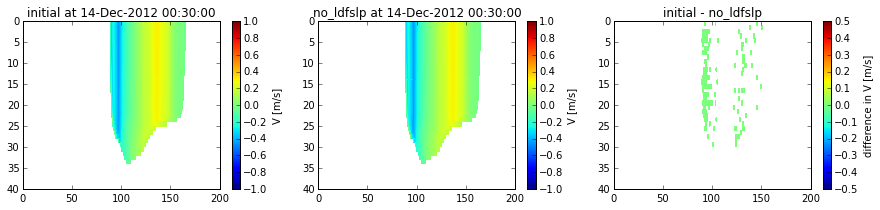

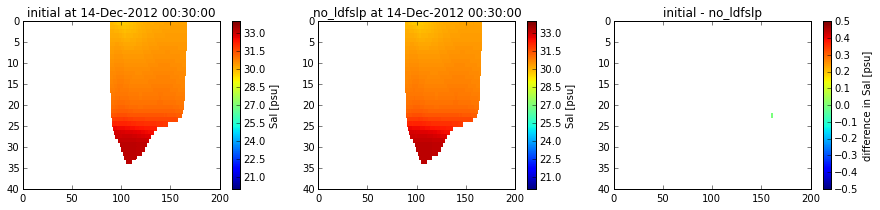

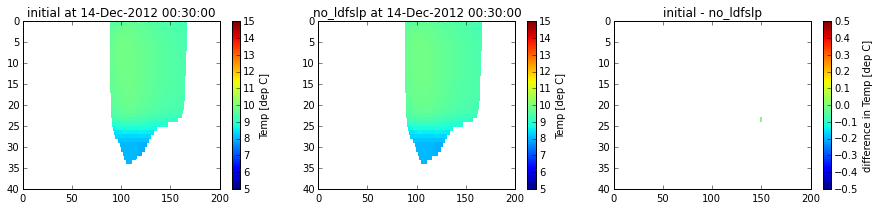

In [22]:
t=0
compare_slice(Us,'U [m/s]', 2, np.arange(300,500), t)
compare_slice(Vs,'V [m/s]', 2, np.arange(300,500), t)
compare_slice(Ss,'Sal [psu]', 2, np.arange(300,500), t,vmin=20,vmax=34)
compare_slice(Ts,'Temp [dep C]', 2, np.arange(300,500), t,vmin=5,vmax=15)

print 'Mouth of JdF at t = {}'.format(t)

Max difference time

Mouth of JdF at t = 5


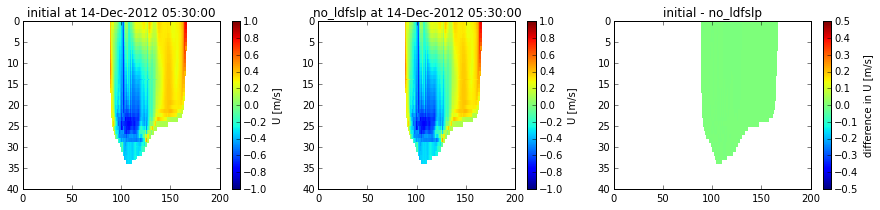

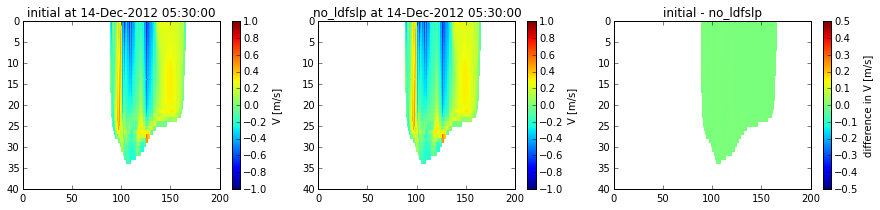

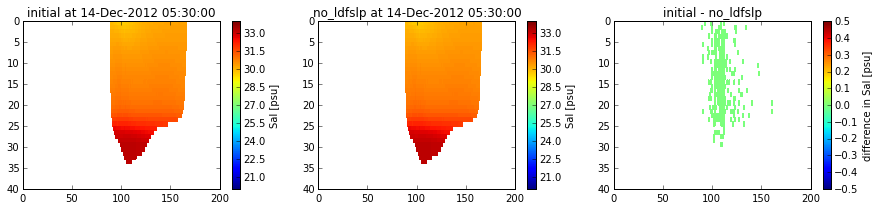

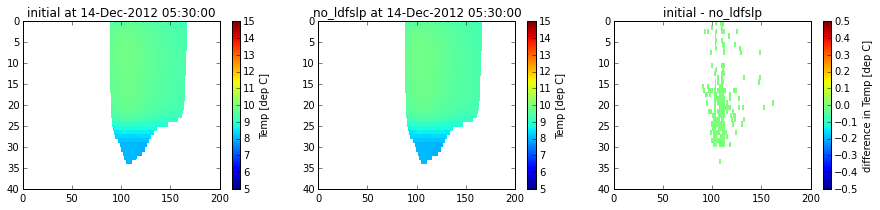

In [23]:
t=5
compare_slice(Us,'U [m/s]', 2, np.arange(300,500), t)
compare_slice(Vs,'V [m/s]', 2, np.arange(300,500), t)
compare_slice(Ss,'Sal [psu]', 2, np.arange(300,500), t,vmin=20,vmax=34)
compare_slice(Ts,'Temp [dep C]', 2, np.arange(300,500), t,vmin=5,vmax=15)

print 'Mouth of JdF at t = {}'.format(t)

Last time

Mouth of JdF at t = 23


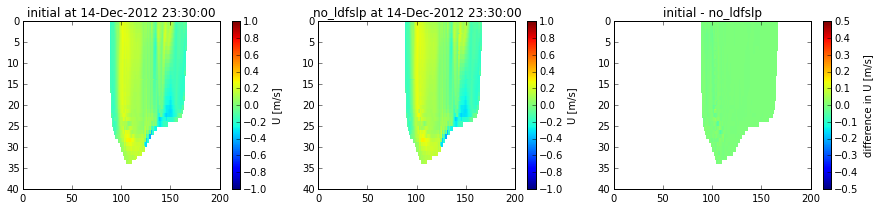

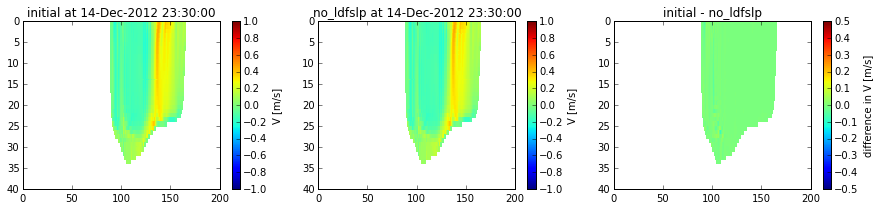

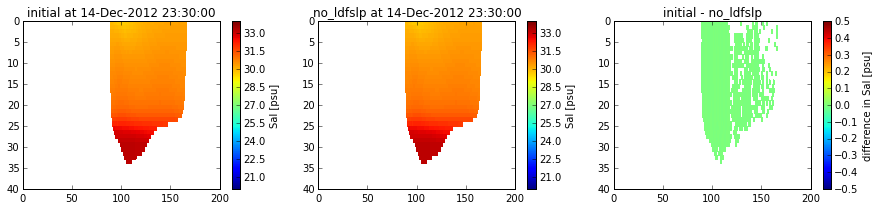

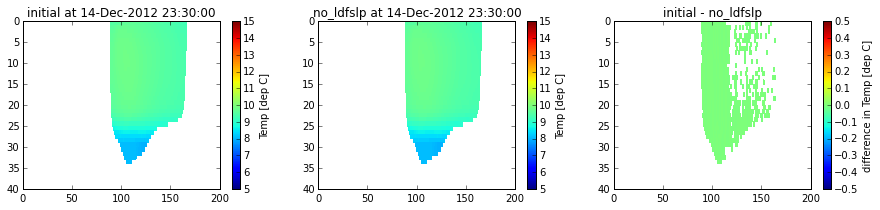

In [24]:
t=23
compare_slice(Us,'U [m/s]', 2, np.arange(300,500), t)
compare_slice(Vs,'V [m/s]', 2, np.arange(300,500), t)
compare_slice(Ss,'Sal [psu]', 2, np.arange(300,500), t,vmin=20,vmax=34)
compare_slice(Ts,'Temp [dep C]', 2, np.arange(300,500), t,vmin=5,vmax=15)

print 'Mouth of JdF at t = {}'.format(t)

* Again, almost no differnce close to the boundary

#Summary

* the key_ldfslp makes a small difference in u/v/temp/sal, mostly in high mixing regions. 
* Particularly, the eddy off Saturna Island on the flood tide has major differences. 
* Overall, the fields are very similar and you can only notice the difference if you take a difference plot. So on the large scale, I don't think this key will affect much.
* This key will not explain all of the differences between 3.4 3.6, especially the differences near the open boundaries.